# FCCU Monitoring via Classical PCA


## Heat exchanger fouling scenario

In [134]:
# import packages 
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [135]:
# fetch NOC training data
data_train = pd.read_csv('NOC_varyingFeedFlow_outputs.csv', header=None).values
data_train = data_train[:,1:] # first column gives sampling time

N = data_train.shape[0]
m = data_train.shape[1]

In [136]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     Fit PCA model and generate monitoring charts for training dataset
############################################################################### 

In [137]:
# mean_center and scale NOC data
scaler = StandardScaler()
scaler.fit(data_train)
scaler.scale_[[3,4,16]] = 1 # these columns have negligible variance and therefore are not scaled to avoid division by zero or very small numbers

data_train_normal = scaler.transform(data_train)

In [138]:
# fit PCA model
pca = PCA()
score_train = pca.fit_transform(data_train_normal)

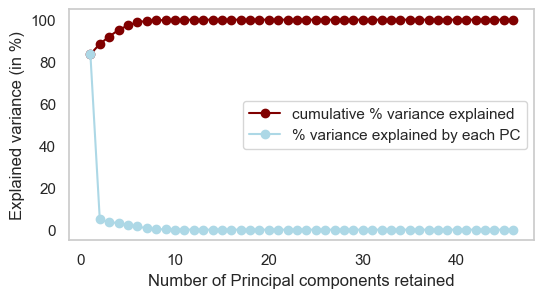

In [139]:
# plot scree plot
explained_variance = 100*pca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained

plt.figure(figsize=(6,3))
plt.plot(range(1, len(explained_variance) + 1), cum_explained_variance, color='maroon', marker='o', label = 'cumulative % variance explained')
plt.plot(range(1, len(explained_variance) + 1), explained_variance, color='lightblue', marker='o', label = '% variance explained by each PC')
plt.ylabel('Explained variance (in %)')
plt.xlabel('Number of Principal components retained')
plt.legend()
plt.grid()
plt.show()

In [140]:
# decide # of PCs to retain and compute reduced data in PC space
n_comp = np.argmax(cum_explained_variance >= 90) + 1
score_train_reduced = score_train[:,0:n_comp]

print('Number of PCs cumulatively explaining atleast 95% variance: ', n_comp)

Number of PCs cumulatively explaining atleast 95% variance:  3


In [141]:
# reconstruct original data
V_matrix = pca.components_.T
P_matrix = V_matrix[:,0:n_comp] 
data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)

In [142]:
# calculate T2 for training data
k = n_comp

lambda_k = np.diag(pca.explained_variance_[0:k]) # eigenvalue = explained variance
lambda_k_inv = np.linalg.inv(lambda_k)

T2_train = np.zeros((N,))
for i in range(N):
    T2_train[i] = np.dot(np.dot(score_train_reduced[i,:], lambda_k_inv), score_train_reduced[i,:].T)

In [143]:
#% calculate Q for training data
error_train = data_train_normal - data_train_normal_reconstruct
Q_train = np.sum(error_train*error_train, axis = 1)

In [144]:
# control limits
T2_CL = np.percentile(T2_train, 99)
Q_CL = np.percentile(Q_train, 99)

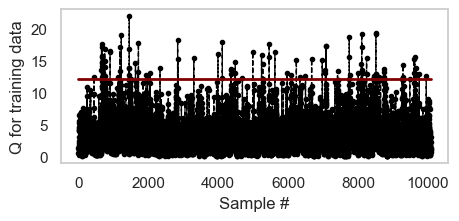

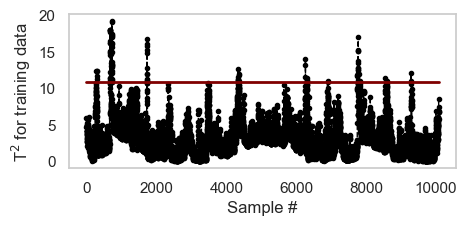

In [145]:
# Q_train plot with CL
plt.figure(figsize=(5,2))
plt.plot(Q_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(Q_train)],[Q_CL,Q_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('Q for training data')
plt.grid()
           
# T2_train plot with CL
plt.figure(figsize=(5,2))
plt.plot(T2_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(T2_train)],[T2_CL,T2_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()
plt.show()

In [146]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                       Faulty data analysis
############################################################################### 

In [147]:
# get test data, normalize it
data_test = pd.read_csv('UAf_decrease_outputs.csv', header=None).values
data_test = data_test[:,1:]
data_test_normal = scaler.transform(data_test)

In [148]:
# compute scores and reconstruct
score_test = pca.transform(data_test_normal)
score_test_reduced = score_test[:,0:k]
data_test_normal_reconstruct = np.dot(score_test_reduced, P_matrix.T)

In [149]:
#calculate T2_test
T2_test = np.zeros((data_test_normal.shape[0],))
for i in range(data_test_normal.shape[0]):
    T2_test[i] = np.dot(np.dot(score_test_reduced[i,:], lambda_k_inv), score_test_reduced[i,:].T)

In [150]:
#calculate Q_test
error_test = data_test_normal_reconstruct - data_test_normal
Q_test = np.sum(error_test*error_test, axis = 1)

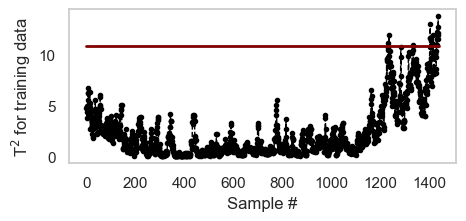

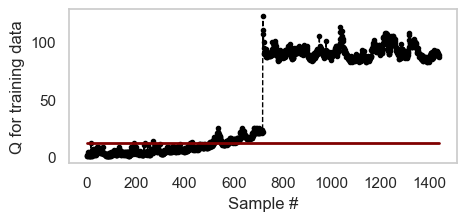

In [ ]:
# plot T2_test
plt.figure(figsize=(5,2))
plt.plot(T2_test, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(T2_test)],[T2_CL,T2_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()

# plot Q_test
plt.figure(figsize=(5,2))
plt.plot(Q_test, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(Q_test)],[Q_CL,Q_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('Q for training data')
plt.grid()
plt.show()

In [152]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                  fault diagnosis using contribution plots
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

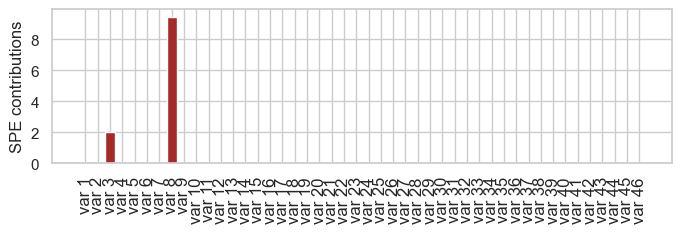

In [153]:
#%% Q contribution
sample = 600

error_test_sample = error_test[sample-1,]
Q_contri = error_test_sample*error_test_sample # vector of contributions

plt.figure(figsize=[8,2])
plt.bar(['var ' + str((i+1)) for i in range(len(Q_contri))], Q_contri, color='brown')
plt.xticks(rotation = 90, fontsize=12)
plt.ylabel('SPE contributions', fontsize=12)
plt.show()

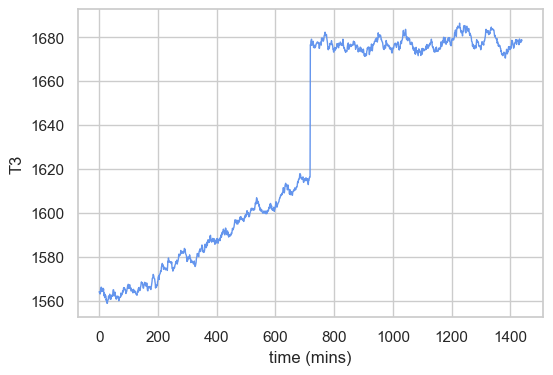

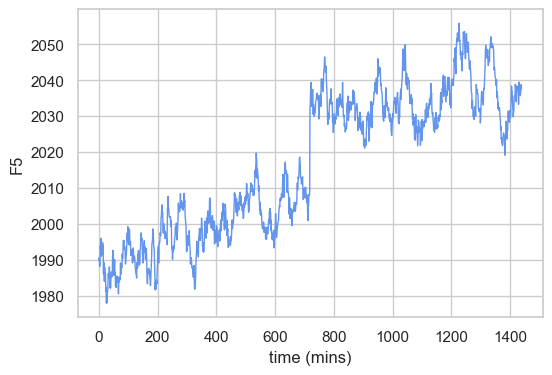

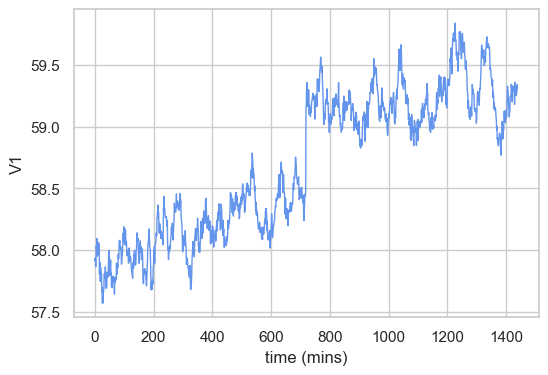

In [154]:
# plot top diagnosed variables
plt.figure(figsize=[6,4])
plt.plot(data_test[:,7],'cornflowerblue', linewidth=1)
plt.xlabel('time (mins)')
plt.ylabel('T3')

plt.figure(figsize=[6,4])
plt.plot(data_test[:,27],'cornflowerblue', linewidth=1)
plt.xlabel('time (mins)')
plt.ylabel('F5')

plt.figure(figsize=[6,4])
plt.plot(data_test[:,21],'cornflowerblue', linewidth=1)
plt.xlabel('time (mins)')
plt.ylabel('V1')
plt.show()